In [20]:
# from __future__ import division
# import numpy as np
# import matplotlib.pyplot as plt
# from src.utils import *

import torch
torch.cuda.is_available()

True

In [21]:
names = ['wine', 'default_credit', 'compas', 'lsat']
bnn_widths = [200, 200, 200, 200]
bnn_depths = [2, 2, 2, 2]

vae_widths = [300, 300, 300, 300] # [200, 200, 200, 200]
vae_depths = [3, 3, 3, 3] # We go deeper because we are using residual models
vae_latent_dims = [6, 8, 4, 4]

# For automatic explainer generation

regression_bools = [True, False, False, True]
gauss_cat_vae_bools = [False, True, True, True]
flat_vae_bools = [False, False, False, False]

var_names = {}
var_names_flat = {}

var_names['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']
var_names_flat['wine'] = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 'chlorides', 'free sulfur dioxide',
            'total sulfur dioxide', 'density', 'pH', 'sulphates', 'alcohol']

var_names['default_credit'] = ['Given credit', 'Gender', 'Education', 'Marital status', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']
var_names_flat['default_credit'] = ['Given credit', 'Gender M', 'Gender F', 'Education grad', 'Education under', 'Education HS', 'Education Other',
                 'Marital status M', 'Marital status S', 'Marital status Other', 'Age', 'Payment delay 1', 'Payment delay 2',
            'Payment delay 3', 'Payment delay 4', 'Payment delay 5', 'Payment delay 6', 'Bill statement 1', 'Bill statement 2',
            'Bill statement 3', 'Bill statement 4', 'Bill statement 5', 'Bill statement 6', 'Previous payment 1', 'Previous payment 2',
            'Previous payment 3', 'Previous payment 4', 'Previous payment 5', 'Previous payment 6']

var_names['compas'] = ["age_cat", "race", "sex", "c_charge_degree", 'is_recid', 'priors_count', 'time_served']
var_names_flat['compas'] = ['25 - 45', 'Greater than 45', 'Less than 25', 'African-American', 'Asian', 'Caucasian', 'Hispanic', 'Native American', 'Other', 'Female', 'Male', 'Felony', 'misdemeanour', 'not_recid', 'is_recid', 'priors_count', 'time_served']

var_names['lsat'] = ['LSAT', 'UGPA', 'race', 'sex']
var_names_flat['lsat'] = ['LSAT', 'UGPA', 'amerind', 'mexican', 'other', 'black', 'asian', 'puerto', 'hisp', 'white', 'female', 'male']


## choose dset

In [22]:
# dname = 'compas'
dname = 'lsat'

# compas

In [23]:
from random import seed
import numpy as np
import os
import urllib.request
import pandas as pd
import datetime
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

def load_UCI(dset_name, splits=10, seed=0, separate_targets=True, save_dir='data/'):
    mkdir(save_dir)

    if dset_name == 'boston':
        if not os.path.isfile(save_dir+'housing.data'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/housing/housing.data",
                               filename=save_dir+'housing.data')
        data = pd.read_csv(save_dir + 'housing.data', header=0, delimiter="\s+").values
        y_idx = [-1]

    elif dset_name == 'concrete':
        if not os.path.isfile(save_dir+'Concrete_Data.xls'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/concrete/compressive/Concrete_Data.xls",
                               filename=save_dir+'Concrete_Data.xls')
        data = pd.read_excel(save_dir+ 'Concrete_Data.xls', header=0, delimiter="\s+").values
        y_idx = [-1]

    elif dset_name == 'energy':
        if not os.path.isfile(save_dir+'ENB2012_data.xlsx'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx",
                               filename=save_dir+'ENB2012_data.xlsx')
        data = pd.read_excel(save_dir+'ENB2012_data.xlsx', header=0, delimiter="\s+").values
        y_idx = [-2, -1]

    elif dset_name == 'power':
        if not os.path.isfile(save_dir+'CCPP.zip'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00294/CCPP.zip",
                               filename=save_dir+'CCPP.zip')
        zipped = zipfile.ZipFile(save_dir+"CCPP.zip")
        data = pd.read_excel(zipped.open('CCPP/Folds5x2_pp.xlsx'), header=0, delimiter="\t").values
        y_idx = [-1]

    elif dset_name == 'wine':
        if not os.path.isfile(save_dir+'winequality-red.csv'):
            urllib.request.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv",
                               filename=save_dir+'winequality-red.csv')
        data = pd.read_csv(save_dir+'winequality-red.csv', header=1, delimiter=';').values
        y_idx = [-1]

    elif dset_name == 'yatch':
        if not os.path.isfile(save_dir+'yacht_hydrodynamics.data'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00243/yacht_hydrodynamics.data",
                               filename=save_dir+'yacht_hydrodynamics.data')
        data = pd.read_csv(save_dir+'yacht_hydrodynamics.data', header=1, delimiter='\s+').values
        y_idx = [-1]

    elif dset_name == 'kin8nm':
        if not os.path.isfile(save_dir+'dataset_2175_kin8nm.csv'):
            urllib.urlretrieve("https://www.openml.org/data/get_csv/3626/dataset_2175_kin8nm.csv",
                               filename=save_dir+'dataset_2175_kin8nm.csv')
        data = pd.read_csv(save_dir+'dataset_2175_kin8nm.csv', header=1, delimiter=',').values
        y_idx = [-1]

    elif dset_name == 'kin8nm':
        if not os.path.isfile(save_dir+'dataset_2175_kin8nm.csv'):
            urllib.urlretrieve("https://www.openml.org/data/get_csv/3626/dataset_2175_kin8nm.csv",
                               filename=save_dir+'dataset_2175_kin8nm.csv')
        data = pd.read_csv(save_dir+'dataset_2175_kin8nm.csv', header=1, delimiter=',').values
        y_idx = [-1]

    elif dset_name == 'naval':
        if not os.path.isfile(save_dir + 'UCI%20CBM%20Dataset.zip'):
            urllib.urlretrieve("http://archive.ics.uci.edu/ml/machine-learning-databases/00316/UCI%20CBM%20Dataset.zip",
                               filename=save_dir + 'UCI%20CBM%20Dataset.zip')
        zipped = zipfile.ZipFile(save_dir + "UCI%20CBM%20Dataset.zip")
        data = pd.read_csv(zipped.open('UCI CBM Dataset/data.txt'), header='infer', delimiter="\s+").values
        y_idx = [-2, -1]

    elif dset_name == 'protein':
        if not os.path.isfile(save_dir+'CASP.csv'):
            urllib.urlretrieve("https://archive.ics.uci.edu/ml/machine-learning-databases/00265/CASP.csv",
                               filename=save_dir+'CASP.csv')
        data = pd.read_csv(save_dir+'CASP.csv', header=1, delimiter=',').values
        y_idx = [0]

    elif dset_name == 'default_credit':
        if not os.path.isfile(save_dir + 'default of credit card clients.xls'):
            urllib.request.urlretrieve(
                "https://archive.ics.uci.edu/ml/machine-learning-databases/00350/default%20of%20credit%20card%20clients.xls",
                filename=save_dir + 'default of credit card clients.xls')
        data = pd.read_excel(save_dir + 'default of credit card clients.xls', header=[0, 1], index_col=0, # delimiter="\s+"
                             ).values
        y_idx = [-1]  # OK


    else:
        raise Exception('Dataset name doesnt match any known datasets.')

    np.random.seed(seed)
    data = data[np.random.permutation(np.arange(len(data)))]

    kf = KFold(n_splits=splits)
    for j, (train_index, test_index) in enumerate(kf.split(data)):

        if separate_targets:
            x_idx = list(range(data.shape[1]))
            for e in y_idx:
                x_idx.remove(x_idx[e])

            x_idx = np.array(x_idx)
            y_idx = np.array(y_idx)
            x_train, y_train = data[train_index, :], data[train_index, :]
            x_train, y_train = x_train[:, x_idx], y_train[:, y_idx]
            x_test, y_test = data[test_index, :], data[test_index, :]
            x_test, y_test = x_test[:, x_idx], y_test[:, y_idx]

            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)
            y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)

            y_stds[y_stds < 1e-10] = 1
            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            y_train = ((y_train - y_means) / y_stds).astype(np.float32)

            x_test = ((x_test - x_means) / x_stds).astype(np.float32)
            y_test = ((y_test - y_means) / y_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds

        else:
            x_train, x_test = data[train_index, :], data[test_index, :]
            x_means, x_stds = x_train.mean(axis=0), x_train.std(axis=0)

            x_stds[x_stds < 1e-10] = 1

            x_train = ((x_train - x_means) / x_stds).astype(np.float32)
            x_test = ((x_test - x_means) / x_stds).astype(np.float32)

            return x_train, x_test, x_means, x_stds

def check_data_file(fname):
    files = os.listdir(".")  # get the current directory listing
    print
    "Looking for file '%s' in the current directory..." % fname

    if fname not in files:
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv"
        
        response = urllib.request.urlopen(addr)

        data = response.read()
        fileOut = open(fname, "wb")
        fileOut.write(data)
        fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."



def get_my_COMPAS(rseed=0, separate_test=True, test_ratio=0.2, save_dir='../data/'):
    """
        The adult dataset can be obtained from: https://raw.githubusercontent.com/propublica/compas-analysis/master/compas-scores-two-years.csv
        The code will look for the data file in the present directory, if it is not found, it will download them from GitHub.
    """

    SEED = rseed
    seed(SEED)
    np.random.seed(SEED)

    their_FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "priors_count", "c_charge_degree"]
    FEATURES_CLASSIFICATION = ["age_cat", "race", "sex", "c_charge_degree", "is_recid", "priors_count",
                               "time_served"]  # features to be used for classification
    CONT_VARIABLES = ["priors_count",
                      "time_served"]  # continuous features, will need to be handled separately from categorical features, categorical features will be encoded using one-hot
    CLASS_FEATURE = "two_year_recid"  # the decision variable


    COMPAS_INPUT_FILE = save_dir + "compas-scores-two-years.csv"
    check_data_file(COMPAS_INPUT_FILE)

    # load the data and get some stats
    df = pd.read_csv(COMPAS_INPUT_FILE)
    df = df.dropna(subset=["days_b_screening_arrest"])  # dropping missing vals

    # convert to np array
    data = df.to_dict('list')
    for k in data.keys():
        data[k] = np.array(data[k])

    dates_in = data['c_jail_in']
    dates_out = data['c_jail_out']
    # this measures time in Jail
    time_served = []
    for i in range(len(dates_in)):
        di = datetime.datetime.strptime(dates_in[i], '%Y-%m-%d %H:%M:%S')
        do = datetime.datetime.strptime(dates_out[i], '%Y-%m-%d %H:%M:%S')
        time_served.append((do - di).days)
    time_served = np.array(time_served)
    time_served[time_served < 0] = 0
    data["time_served"] = time_served

    """ Filtering the data """

    # These filters are the same as propublica (refer to https://github.com/propublica/compas-analysis)
    # If the charge date of a defendants Compas scored crime was not within 30 days from when the person was arrested, we assume that because of data quality reasons, that we do not have the right offense.
    idx = np.logical_and(data["days_b_screening_arrest"] <= 30, data["days_b_screening_arrest"] >= -30)

    # We coded the recidivist flag -- is_recid -- to be -1 if we could not find a compas case at all.
    idx = np.logical_and(idx, data["is_recid"] != -1)

    # In a similar vein, ordinary traffic offenses -- those with a c_charge_degree of 'O' -- will not result in Jail time are removed (only two of them).
    idx = np.logical_and(idx, data["c_charge_degree"] != "O")  # F: felony, M: misconduct

    # We filtered the underlying data from Broward county to include only those rows representing people who had either recidivated in two years, or had at least two years outside of a correctional facility.
    idx = np.logical_and(idx, data["score_text"] != "NA")

    # select the examples that satisfy this criteria
    for k in data.keys():
        print("")
        data[k] = data[k][idx]

    y = data[CLASS_FEATURE]
    """ Feature normalization and one hot encoding """

    print
    "\nNumber of people recidivating within two years"
    print
    pd.Series(y).value_counts()
    print
    "\n"

    X = []  # empty array with num rows same as num examples, will hstack the features to it
    X_dims = []

    feature_names = []
    for i,attr in enumerate(FEATURES_CLASSIFICATION):
        vals = data[attr]
        if attr in CONT_VARIABLES:
            vals = [float(v) for v in vals]
            # vals = preprocessing.scale(vals, axis=0, with_mean=True, with_std=True)  # 0 mean and 1 variance
            vals = np.reshape(vals, (len(y), -1))  # convert from 1-d arr to a 2-d arr with one col
            X_dims.append(1)

        else:  # for binary categorical variables, the label binarizer uses just one var instead of two
            enc = preprocessing.OneHotEncoder(categories='auto', handle_unknown='error')
            enc.fit(vals.reshape(-1, 1))
            vals = enc.transform(vals.reshape(-1, 1)).todense()
            X_dims += [vals.shape[1]]*vals.shape[1]

        # add to learnable features
        X.append(vals)

        if attr in CONT_VARIABLES:  # continuous feature, just append the name
            feature_names.append(attr)
        else:  # categorical features
            if vals.shape[1] == 1:  # binary features that passed through lib binarizer
                feature_names.append(attr)
            else:
                for k in enc.categories_:  # non-binary categorical features, need to add the names for each cat
                    feature_names.append(attr + "_" + str(k))

    X = np.array(np.concatenate(list(X), axis=1))
    X_dims = np.array(X_dims)
    if separate_test:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_ratio, random_state=rseed, shuffle=True)

        x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
        x_means[X_dims>1] = 0
        x_stds[X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X_train - x_means) / x_stds).astype(np.float32)
        x_test = ((X_test - x_means) / x_stds).astype(np.float32)

        return x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims
    else:
        x_means, x_stds = X.mean(axis=0), X.std(axis=0)
        print(X_dims.shape, x_means.shape)
        x_means[:,X_dims>1] = 0
        x_stds[:,X_dims>1] = 1
        x_stds[x_stds < 1e-10] = 1

        x_train = ((X - x_means) / x_stds).astype(np.float32)

        return x_train, x_means, x_stds, y, feature_names, X_dims


def mkdir(paths):
    if not isinstance(paths, (list, tuple)):
        paths = [paths]
    for path in paths:
        if not os.path.isdir(path):
            os.makedirs(path, mode=0o777)
            
def unnormalise_cat_vars(x, x_means, x_stds, input_dim_vec):
    input_dim_vec = np.array(input_dim_vec)
    unnorm_x = np.multiply(x, x_stds) + x_means

    fixed_unnorm = unnorm_x.round()
    # -=
    fixed_unnorm = fixed_unnorm - fixed_unnorm.min(axis=0).reshape([1, fixed_unnorm.shape[1]])  # this sets all mins to 0
    for idx, dims in enumerate(input_dim_vec):
        if dims > 1:
            vec = fixed_unnorm[:, idx]
            vec[vec > dims - 1] = dims - 1
            fixed_unnorm[:, idx] = vec

    x[:, input_dim_vec > 1] = fixed_unnorm[:, input_dim_vec > 1]
    return x

def gauss_cat_to_flat(x, input_dim_vec):
    output = []
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output.append(x[:, idx].unsqueeze(1))
        elif dim > 1:
            oh_vec = torch_onehot(x[:, idx], dim).type(x.type())
            output.append(oh_vec)
        else:
            raise ValueError('Error, invalid dimension value')
    return torch.cat(output, dim=1)


def X_dims_to_input_dim_vec(X_dims):
    """This is for our cat_Gauss VAE model"""
    input_dim_vec = []
    i = 0
    while i < len(X_dims):
        input_dim_vec.append(X_dims[i])
        i += X_dims[i]
    return np.array(input_dim_vec)

# LSAT

In [24]:
#from __future__ import division
import os
import numpy as np
import pandas as pd
import urllib


def check_data_file(fdir):
    fname = os.path.join(fdir, 'law_school_cf_test.csv')

    if not os.path.isfile(fname):
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/throwaway20190523/MonotonicFairness/master/data/law_school_cf_test.csv"
        #response = urllib3.urlopen(addr)
        urllib.request.urlretrieve(addr,filename=fname)
        #data = pd.read_csv(fname, header=1, delimiter = ";").values
        #fileOut = open(fname, "w")
        #fileOut.write(data)
        #fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

    fname = os.path.join(fdir, 'law_school_cf_train.csv')

    if not os.path.isfile(fname):
        print
        "'%s' not found! Downloading from GitHub..." % fname
        addr = "https://raw.githubusercontent.com/throwaway20190523/MonotonicFairness/master/data/law_school_cf_train.csv"
        urllib.request.urlretrieve(addr,filename=fname)
        #data = response.read()
        #fileOut = open(fname, "w")
        #fileOut.write(data)
        #fileOut.close()
        print
        "'%s' download and saved locally.." % fname
    else:
        print
        "File found in current directory.."

    return None


def input_dim_vec_to_X_dims(input_dim_vec):
    """This is for our cat_Gauss VAE model"""
    X_dims = []
    for i in input_dim_vec:
        for ii in range(i):
            X_dims.append(i)
    return np.array(X_dims)


def get_my_LSAT(save_dir='../data/'):
    # The loaded files have a test set size of 0.2
    check_data_file(save_dir)

    train_file = save_dir + 'law_school_cf_train.csv'
    test_file = save_dir + 'law_school_cf_test.csv'


    df = pd.read_csv(train_file)
    data_train = df.to_dict('list')
    
    # print(test_file)
    
    df = pd.read_csv(test_file)
    data_test = df.to_dict('list')

    keys = list(data_train.keys())

    # I reorder the keys so they make a little bit more sense

    target_key = 'ZFYA'
    # we are going to exclude
    my_data_keys = ['LSAT','UGPA',
                    'amerind', 'mexican','other','black','asian','puerto','hisp','white',
                    'female', 'male']
    input_dim_vec = [1, 1, 8, 2]
    X_dims = input_dim_vec_to_X_dims(input_dim_vec)

    X_train = np.empty((len(data_train[keys[0]]), len(my_data_keys)))
    y_train = np.array(data_train[target_key]).reshape(-1, 1)
    X_test = np.empty((len(data_test[keys[0]]), len(my_data_keys)))
    y_test = np.array(data_test[target_key]).reshape(-1, 1)

    for k_idx, k in enumerate(my_data_keys):
        X_train[:, k_idx] = np.array(data_train[k])
        X_test[:, k_idx] = np.array(data_test[k])

    x_means, x_stds = X_train.mean(axis=0), X_train.std(axis=0)
    x_means[X_dims>1] = 0
    x_stds[X_dims>1] = 1
    x_stds[x_stds < 1e-10] = 1

    x_train = ((X_train - x_means) / x_stds).astype(np.float32)
    x_test = ((X_test - x_means) / x_stds).astype(np.float32)

    y_means, y_stds = y_train.mean(axis=0), y_train.std(axis=0)
    y_stds[y_stds < 1e-10] = 1

    y_train = ((y_train - y_means) / y_stds).astype(np.float32)
    y_test = ((y_test - y_means) / y_stds).astype(np.float32)

    return x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, my_data_keys, input_dim_vec


def join_LSAT_targets(x_train, x_test, y_train, y_test, input_dim_vec):
    input_dim_vec = np.append(input_dim_vec, 1)

    x_train = np.concatenate([x_train, y_train], axis=1)
    x_test = np.concatenate([x_test, y_test], axis=1)
    return x_train, x_test, input_dim_vec

# Choose it....

In [25]:
# from src.UCI_loader import load_UCI, unnormalise_cat_vars
# from src.compas_loader import get_my_COMPAS, X_dims_to_input_dim_vec
# from src.LSAT_loader import get_my_LSAT
# from src.gauss_cat import gauss_cat_to_flat


if dname == 'wine':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
    load_UCI(dset_name='wine', splits=10, seed=42, separate_targets=True, save_dir='../data/')
    
elif dname == 'default_credit':
    # Note that this dataset is given without flattening
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds = \
    load_UCI(dset_name='default_credit', splits=10, seed=42, separate_targets=True, save_dir='../data/')
    print('Credit', x_train.shape, x_test.shape)
    input_dim_vec = [1, 2, 4, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 ,1 ,1 ,1 ,1 ,1]
    
    x_train = unnormalise_cat_vars(x_train, x_means, x_stds, input_dim_vec)
    x_test = unnormalise_cat_vars(x_test, x_means, x_stds, input_dim_vec)
    # target unnormalisation
    y_train = unnormalise_cat_vars(y_train, y_means, y_stds, [2])
    y_test = unnormalise_cat_vars(y_test, y_means, y_stds, [2])
    
    x_train = gauss_cat_to_flat(torch.Tensor(x_train), input_dim_vec)
    x_test = gauss_cat_to_flat(torch.Tensor(x_test), input_dim_vec)

    print(input_dim_vec)

elif dname == 'compas':
    x_train, x_test, x_means, x_stds, y_train, y_test, feature_names, X_dims = \
    get_my_COMPAS(rseed=42, separate_test=True, test_ratio=0.1, save_dir='../data/')
    input_dim_vec = X_dims_to_input_dim_vec(X_dims)
    print('Compas', x_train.shape, x_test.shape)
    print(input_dim_vec)
    
elif dname == 'lsat':
    x_train, x_test, x_means, x_stds, y_train, y_test, y_means, y_stds, my_data_keys, input_dim_vec = \
    get_my_LSAT(save_dir='../data/')
    print('LSAT', x_train.shape, x_test.shape)
    print(input_dim_vec)

LSAT (17432, 12) (4358, 12)
[1, 1, 8, 2]


In [26]:
import torch.utils.data as data

class Datafeed(data.Dataset):

    def __init__(self, x_train, y_train=None, transform=None):
        self.data = x_train
        self.targets = y_train
        self.transform = transform

    def __getitem__(self, index):
        img = self.data[index]
        if self.transform is not None:
            img = self.transform(img)
        if self.targets is not None:
            return img, self.targets[index]
        else:
            return img

    def __len__(self):
        return len(self.data)

In [27]:
# from src.utils import Datafeed

trainset = Datafeed(x_train, y_train, transform=None)
valset = Datafeed(x_test, y_test, transform=None)

print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(17432, 12) (17432, 1) (4358, 12) (4358, 1)


### BNN LOADING

In [28]:
import torch.nn as nn

class MLP_gauss(nn.Module):
    def __init__(self, input_dim, width, depth, output_dim, flatten_image):
        super(MLP_gauss, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.flatten_image = flatten_image

#         layers = [nn.Linear(input_dim, width), nn.ReLU()]
#         for i in range(depth - 1):
#             layers.append(nn.Linear(width, width))
#             layers.append(nn.ReLU())
#         layers.append(nn.Linear(width, 2*output_dim))
        
        layers = [nn.Linear(input_dim,2*output_dim)]

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        # if self.flatten_image:
        #     x = x.view(-1, self.input_dim)
        x = self.block(x)
        mu = x[:, :self.output_dim]
        sigma = F.softplus(x[:, self.output_dim:])
        return mu, sigma

In [29]:
class BaseNet(object):
    def __init__(self):
        cprint('c', '\nNet:')

    def get_nb_parameters(self):
        return np.sum(np.fromiter((p.numel() for p in self.model.parameters()),int))
#         return np.sum(np.fromiter(p.numel() for p in self.model.parameters(),dtype=int))
#         k = np.sum()
#         print(type(k))
        return np.sum(p.numel() for p in self.model.parameters())

    def set_mode_train(self, train=True):
        if train:
            self.model.train()
        else:
            self.model.eval()

    def update_lr(self, epoch, gamma=0.99):
        self.epoch += 1
        if self.schedule is not None:
            if len(self.schedule) == 0 or epoch in self.schedule:
                self.lr *= gamma
                print('learning rate: %f  (%d)\n' % (self.lr, epoch))
                for param_group in self.optimizer.param_groups:
                    param_group['lr'] = self.lr

#     def save(self, filename):
#         cprint('c', 'Writting %s\n' % filename)
#         torch.save({
#             'epoch': self.epoch,
#             'lr': self.lr,
#             'model': self.model,
#             'optimizer': self.optimizer}, filename)
    def save(self,filename):
        cprint('c', 'Writting %s\n' % filename)
        torch.save({
            'epoch': self.epoch,
            'lr': self.lr,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
        }, filename)


#     def load(self, filename):
#         cprint('c', 'Reading %s\n' % filename)
#         state_dict = torch.load(filename)
#         self.epoch = state_dict['epoch']
#         self.lr = state_dict['lr']
# #         self.model = state_dict['model']
#         self.optimizer = state_dict['optimizer']
#         print('  restoring epoch: %d, lr: %f' % (self.epoch, self.lr))
#         return self.epoch

    def load(self,filename):
        cprint('c', 'Reading %s\n' % filename)
        state_dict = torch.load(filename)
        self.epoch = state_dict['epoch']
        self.lr = state_dict['lr']
        # self.model = state_dict['model_state_dict']
        self.model.load_state_dict(state_dict['model_state_dict'])
        self.optimizer.load_state_dict(state_dict['optimizer_state_dict'])

In [30]:
from torch.optim import Optimizer


class H_SA_SGHMC(Optimizer):
    """ Stochastic Gradient Hamiltonian Monte-Carlo Sampler that uses a burn-in
        procedure to adapt its own hyperparameters during the initial stages
        of sampling."""

    def __init__(self, params, lr=1e-2, base_C=0.05, gauss_sig=0.1, alpha0=10, beta0=10):
        """ Set up a SGHMC Optimizer.
        Parameters
        ----------
        params : iterable
            Parameters serving as optimization variable.
        lr: float, optional
            Base learning rate for this optimizer.
            Must be tuned to the specific function being minimized.
            Default: `1e-2`.
        base_C:float, optional
            (Constant) momentum decay per time-step.
            Default: `0.05`.
        """

        self.eps = 1e-6
        self.alpha0 = alpha0
        self.beta0 = beta0

        if gauss_sig == 0:
            self.weight_decay = 0
        else:
            self.weight_decay = 1 / (gauss_sig ** 2)

        if self.weight_decay <= 0.0:
            raise ValueError("Invalid weight_decay value: {}".format(weight_decay))
        if lr < 0.0:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if base_C < 0:
            raise ValueError("Invalid friction term: {}".format(base_C))

        defaults = dict(
            lr=lr,
            base_C=base_C,
        )
        super(H_SA_SGHMC, self).__init__(params, defaults)

    def step(self, burn_in=False, resample_momentum=False, resample_prior=False):
        """Simulate discretized Hamiltonian dynamics for one step"""
        loss = None

        for group in self.param_groups:  # iterate over blocks -> the ones defined in defaults. We dont use groups.
            for p in group["params"]:  # these are weight and bias matrices
                if p.grad is None:
                    continue
                state = self.state[p]  # define dict for each individual param
                if len(state) == 0:
                    state["iteration"] = 0
                    state["tau"] = torch.ones_like(p)
                    state["g"] = torch.ones_like(p)
                    state["V_hat"] = torch.ones_like(p)
                    state["v_momentum"] = torch.zeros_like(
                        p)  # p.data.new(p.data.size()).normal_(mean=0, std=np.sqrt(group["lr"])) #
                    state['weight_decay'] = self.weight_decay

                state["iteration"] += 1  # this is kind of useless now but lets keep it provisionally

                if resample_prior:
                    alpha = self.alpha0 + p.data.nelement() / 2
                    beta = self.beta0 + (p.data ** 2).sum().item() / 2
                    gamma_sample = gamma(shape=alpha, scale=1 / (beta), size=None)
                    #                     print('std', 1/np.sqrt(gamma_sample))
                    state['weight_decay'] = gamma_sample

                base_C, lr = group["base_C"], group["lr"]
                weight_decay = state["weight_decay"]
                tau, g, V_hat = state["tau"], state["g"], state["V_hat"]

                d_p = p.grad.data
                if weight_decay != 0:
                    d_p.add_(weight_decay, p.data)

                # update parameters during burn-in
                if burn_in:  # We update g first as it makes most sense
                    tau.add_(-tau * (g ** 2) / (
                                V_hat + self.eps) + 1)  # specifies the moving average window, see Eq 9 in [1] left
                    tau_inv = 1. / (tau + self.eps)
                    g.add_(-tau_inv * g + tau_inv * d_p)  # average gradient see Eq 9 in [1] right
                    V_hat.add_(-tau_inv * V_hat + tau_inv * (d_p ** 2))  # gradient variance see Eq 8 in [1]

                V_sqrt = torch.sqrt(V_hat)
                V_inv_sqrt = 1. / (V_sqrt + self.eps)  # preconditioner

                if resample_momentum:  # equivalent to var = M under momentum reparametrisation
                    state["v_momentum"] = torch.normal(mean=torch.zeros_like(d_p),
                                                       std=torch.sqrt((lr ** 2) * V_inv_sqrt))
                v_momentum = state["v_momentum"]

                noise_var = (2. * (lr ** 2) * V_inv_sqrt * base_C - (lr ** 4))
                noise_std = torch.sqrt(torch.clamp(noise_var, min=1e-16))
                # sample random epsilon
                noise_sample = torch.normal(mean=torch.zeros_like(d_p), std=torch.ones_like(d_p) * noise_std)

                # update momentum (Eq 10 right in [1])
                v_momentum.add_(- (lr ** 2) * V_inv_sqrt * d_p - base_C * v_momentum + noise_sample)

                # update theta (Eq 10 left in [1])
                p.data.add_(v_momentum)

        return loss

In [31]:
def load_object(filename):
    with open(filename, 'rb') as input:
        
        from collections import OrderedDict
        
        samples = pickle.load(input, encoding='bytes')
        new_samples = []
        for i,weight_dict in enumerate(samples):
            new_weight_dict = OrderedDict()
            for key in weight_dict:
                new_weight_dict[key.decode("utf-8")] = weight_dict[key]
            new_samples.append(new_weight_dict)
        return new_samples
#         try:
#             return pickle.load(input)
#         except Exception as e:
#             try:
#                 print(e)
#                 return pickle.load(input, encoding="latin1")
#             except Exception as a:
#                 print(a)
#                 return pickle.load(input, encoding='bytes')

In [66]:
import sys
import torch.backends.cudnn as cudnn
import pickle
import torch.nn.functional as F


class BNN_cat(BaseNet):  # for categorical distributions
    def __init__(self, model, N_train, lr=1e-2, cuda=True, grad_std_mul=30, seed=None):
        super(BNN_cat, self).__init__()

        cprint('y', 'BNN categorical output')
        self.lr = lr
        self.model = model
        self.cuda = cuda
        self.seed = seed

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = None  # [] #[50,200,400,600]
        self.epoch = 0

        self.grad_buff = []
        self.max_grad = 1e20
        self.grad_std_mul = grad_std_mul

        self.weight_set_samples = []

    def create_net(self):
        if self.seed is None:
            torch.manual_seed(42)
        else:
            torch.manual_seed(self.seed)
        if self.cuda:
            if self.seed is None:
                torch.cuda.manual_seed(42)
            else:
                torch.cuda.manual_seed(self.seed)
        if self.cuda:
            self.model.cuda()
            cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        """This optimiser incorporates the gaussian prior term automatically. The prior variance is gibbs sampled from
        its posterior using a gamma hyper-prior."""
        self.optimizer = H_SA_SGHMC(params=self.model.parameters(), lr=self.lr, base_C=0.05, gauss_sig=0.1)  # this last parameter does nothing

    def fit(self, x, y, burn_in=False, resample_momentum=False, resample_prior=False):
        self.set_mode_train(train=True)
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)
        self.optimizer.zero_grad()
        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='mean')
        loss = loss * self.N_train  # We use mean because we treat as an estimation of whole dataset
        loss.backward()

        if len(self.grad_buff) > 1000:
            self.max_grad = np.mean(self.grad_buff) + self.grad_std_mul * np.std(self.grad_buff)
            self.grad_buff.pop(0)

        self.grad_buff.append(nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
                                                       max_norm=self.max_grad, norm_type=2))
        if self.grad_buff[-1] >= self.max_grad:
            print(self.max_grad, self.grad_buff[-1])
            self.grad_buff.pop()
        self.optimizer.step(burn_in=burn_in, resample_momentum=resample_momentum, resample_prior=resample_prior)

        # out: (batch_size, out_channels, out_caps_dims)
        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data * x.shape[0] / self.N_train, err

    def eval(self, x, y, train=False):
        self.set_mode_train(train=False)
        x, y = to_variable(var=(x, y.long()), cuda=self.cuda)

        out = self.model(x)
        loss = F.cross_entropy(out, y, reduction='sum')
        probs = F.softmax(out, dim=1).data.cpu()

        pred = out.data.max(dim=1, keepdim=False)[1]  # get the index of the max log-probability
        err = pred.ne(y.data).sum()

        return loss.data, err, probs

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))
        return None

    def predict(self, x):
        self.set_mode_train(train=False)
        x, = to_variable(var=(x, ), cuda=self.cuda)
        out = self.model(x)
        probs = F.softmax(out, dim=1).data.cpu()
        return probs.data

    def sample_predict(self, x, Nsamples, grad=False):
        """return predictions using multiple samples from posterior"""
        self.set_mode_train(train=False)
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
        x, = to_variable(var=(x, ), cuda=self.cuda)

        if grad:
            self.optimizer.zero_grad()
            if not x.requires_grad:
                x.requires_grad = True

        out = x.data.new(Nsamples, x.shape[0], self.model.output_dim)

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            out[idx] = self.model(x)

        out = out[:idx]
        prob_out = F.softmax(out, dim=2)

        if grad:
            return prob_out
        else:
            return prob_out.data

    def get_weight_samples(self, Nsamples=0):
        """return weight samples from posterior in a single-column array"""
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break

            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)

    def save_weights(self, filename):
        save_object(self.weight_set_samples, filename)

    def load_weights(self, filename, subsample=1):
        self.weight_set_samples = load_object(filename)
        self.weight_set_samples = self.weight_set_samples[::subsample]


class BNN_gauss(BaseNet):
    def __init__(self, model, N_train, lr=1e-2, cuda=True, eps=1e-3, grad_std_mul=20):
        super(BNN_gauss, self).__init__()
        cprint('y', ' Creating Net!! ')
        cprint('y', 'BNN gaussian output')
        self.lr = lr
        self.model = model
        self.cuda = cuda

        self.N_train = N_train
        self.create_net()
        self.create_opt()
        self.schedule = None  # [] #[50,200,400,600]
        self.epoch = 0

        self.grad_buff = []
        self.grad_std_mul = grad_std_mul
        self.max_grad = 1e20
        self.eps = eps

        self.weight_set_samples = []

    def create_net(self):
        torch.manual_seed(42)
        if self.cuda:
            torch.cuda.manual_seed(42)

        if self.cuda:
            self.model.cuda()
            cudnn.benchmark = True

        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = H_SA_SGHMC(params=self.model.parameters(), lr=self.lr, base_C=0.05, gauss_sig=0.1)

    def fit(self, x, y, burn_in=False, resample_momentum=False, resample_prior=False):
        self.set_mode_train(train=True)
        x, y = to_variable(var=(x, y), cuda=self.cuda)

        self.optimizer.zero_grad()
        mu, sigma = self.model(x)
        sigma = sigma.clamp(min=self.eps)
        loss = -diagonal_gauss_loglike(y, mu, sigma).mean(dim=0) * self.N_train

        loss.backward()
        if len(self.grad_buff) > 100:
            self.max_grad = np.mean(self.grad_buff) + self.grad_std_mul * np.std(self.grad_buff)
            self.grad_buff.pop(0)

        self.grad_buff.append(nn.utils.clip_grad_norm_(parameters=self.model.parameters(),
                                                       max_norm=self.max_grad, norm_type=2))
        if self.grad_buff[-1] >= self.max_grad:
            print(self.max_grad, self.grad_buff[-1])
            self.grad_buff.pop()
        self.optimizer.step(burn_in=burn_in, resample_momentum=resample_momentum, resample_prior=resample_prior)

        return loss.data * x.shape[0] / self.N_train, mu.data, sigma.data

    def eval(self, x, y):
        self.set_mode_train(train=False)
        x, y = to_variable(var=(x, y), cuda=self.cuda)
        mu, sigma = self.model(x)
        sigma = sigma.clamp(min=self.eps)
        loss = -diagonal_gauss_loglike(y, mu, sigma).mean(dim=0) * self.N_train

        return loss.data * x.shape[0] / self.N_train, mu.data, sigma.data

    @staticmethod
    def unnormalised_eval(pred_mu, pred_std, y, y_mu, y_std, gmm=False):
        ll = get_loglike(pred_mu, pred_std, y, y_mu, y_std, gmm=gmm)  # this already computes sum
        if gmm:
            pred_mu = pred_mu.mean(dim=0)
        rms = get_rms(pred_mu, y, y_mu, y_std)  # this already computes sum
        return rms, ll

    def predict(self, x):
        self.set_mode_train(train=False)
        x, = to_variable(var=(x,), cuda=self.cuda)
        mu, sigma = self.model(x)
        return mu.data, sigma.data

    def save_sampled_net(self, max_samples):

        if len(self.weight_set_samples) >= max_samples:
            self.weight_set_samples.pop(0)

        self.weight_set_samples.append(copy.deepcopy(self.model.state_dict()))

        cprint('c', ' saving weight samples %d/%d' % (len(self.weight_set_samples), max_samples))

        return None

    def sample_predict(self, x, Nsamples, grad=False):
        self.set_mode_train(train=False)
        if Nsamples == 0:
            Nsamples = len(self.weight_set_samples)
        x, = to_variable(var=(x, ), cuda=self.cuda)

        if grad:
            self.optimizer.zero_grad()
            if not x.requires_grad:
                x.requires_grad = True

        mu_vec = x.data.new(Nsamples, x.shape[0], self.model.output_dim)
        std_vec = x.data.new(Nsamples, x.shape[0], self.model.output_dim)

        # iterate over all saved weight configuration samples
        for idx, weight_dict in enumerate():
            if idx == Nsamples:
                break
            self.model.load_state_dict(weight_dict)
            mu_vec[idx], std_vec[idx] = self.model(x)

        if grad:
            return mu_vec[:idx], std_vec[:idx]
        else:
            return mu_vec[:idx].data, std_vec[:idx].data


    def get_weight_samples(self, Nsamples=0):
        weight_vec = []

        if Nsamples == 0 or Nsamples > len(self.weight_set_samples):
            Nsamples = len(self.weight_set_samples)

        for idx, state_dict in enumerate(self.weight_set_samples):
            if idx == Nsamples:
                break

            for key in state_dict.keys():
                if 'weight' in key:
                    weight_mtx = state_dict[key].cpu().data
                    for weight in weight_mtx.view(-1):
                        weight_vec.append(weight)

        return np.array(weight_vec)

    def save_weights(self, filename):
        save_object(self.weight_set_samples, filename)

    def load_weights(self, filename):
        self.weight_set_samples = load_object(filename)


class MLP(nn.Module):
    def __init__(self, input_dim, width, depth, output_dim, flatten_image):
        super(MLP, self).__init__()

        self.input_dim = input_dim
        self.output_dim = output_dim
        self.width = width
        self.depth = depth
        self.flatten_image = flatten_image

        layers = [nn.Linear(input_dim, width), nn.ReLU(inplace=True)]
        for i in range(depth - 1):
            layers.append(nn.Linear(width, width))
            layers.append(nn.ReLU(inplace=True))
        layers.append(nn.Linear(width, output_dim))

        self.block = nn.Sequential(*layers)

    def forward(self, x):
        # if self.flatten_image:
        #    x = x.view(-1, self.input_dim)
        return self.block(x)

def cprint(color, text, **kwargs):
    if color[0] == '*':
        pre_code = '1;'
        color = color[1:]
    else:
        pre_code = ''
    code = {
        'a': '30',
        'r': '31',
        'g': '32',
        'y': '33',
        'b': '34',
        'p': '35',
        'c': '36',
        'w': '37'
    }
    print("\x1b[%s%sm%s\x1b[0m" % (pre_code, code[color], text), **kwargs)
    sys.stdout.flush()

In [67]:
# from __future__ import division
# %matplotlib inline

import torch
from torchvision import datasets, transforms
# from BNN.models import MLP_gauss
# from BNN.wrapper import BNN_gauss, BNN_cat, MLP
import numpy as np

if regression_bools[names.index(dname)]:
    
    input_dim = x_train.shape[1]
    width = bnn_widths[names.index(dname)]
    depth = bnn_depths[names.index(dname)]
    output_dim = y_train.shape[1]
    model = MLP_gauss(input_dim, width, depth, output_dim, flatten_image=False)

    N_train = x_train.shape[0]
    lr = 1e-2
    cuda = torch.cuda.is_available()
    BNN = BNN_gauss(model, N_train, lr=lr, cuda=cuda)
    
else:
    N_train = x_train.shape[0]
    input_dim = x_train.shape[1]
    width = bnn_widths[names.index(dname)]
    depth = bnn_depths[names.index(dname)]
    output_dim = 2
    model = MLP(input_dim, width, depth, output_dim, flatten_image=False)

    lr = 1e-2
    cuda = torch.cuda.is_available()
    BNN = BNN_cat(model, N_train, lr=lr, cuda=cuda)



save_dir = '../saves/fc_BNN_NEW_' + dname

print(save_dir + '_models/state_dicts.pkl')

BNN.load_weights(save_dir + '_models/state_dicts.pkl')


Net:
 Creating Net!! 
BNN gaussian output
    Total params: 0.00M
../saves/fc_BNN_NEW_lsat_models/state_dicts.pkl


### VAE

In [68]:
##### ADDED STUFF

def selective_softmax(x, input_dim_vec, grad=False, cat_probs=False, prob_sample=False, eps=1e-20):
    """Applies softmax operation to specified dimensions. Gradient estimator is optional.
    cat_probs returns probability vectors over categorical variables instead of maxing
    if cat_probs is activated with prob sample, a one-hot vector will be sampled (reparametrisable)"""
    output = torch.zeros_like(x)
    cum_dims = 0
    for idx, dim in enumerate(input_dim_vec):
        if dim == 1:
            output[:, cum_dims] = x[:, cum_dims]
            if prob_sample:  # this assumes an rms loss when training
                noise = x.new_zeros(x.shape[0]).normal_(mean=0, std=1)
                output[:, cum_dims] = output[:, cum_dims] + noise
            cum_dims += 1
        elif dim > 1:
            if not cat_probs:
                if not grad:
                    y = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_vec = torch_onehot(y, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = y_vec
                else:
                    x_cat = x[:, cum_dims:cum_dims + dim]
                    probs = F.softmax(x_cat, dim=1)
                    y_hard = x[:, cum_dims:cum_dims + dim].max(dim=1)[1]
                    y_oh = torch_onehot(y_hard, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = (y_oh - probs).detach() + probs
            else:
                x_cat = x[:, cum_dims:cum_dims + dim]
                probs = F.softmax(x_cat, dim=1)

                if prob_sample:  # we are going to use gumbel trick here
                    log_probs = torch.log(probs)
                    u = log_probs.new(log_probs.shape).uniform_(0, 1)
                    g = -torch.log(-torch.log(u + eps) + eps)
                    cat_samples = (log_probs + g).max(dim=1)[1]
                    hard_samples = torch_onehot(cat_samples, dim).type(x.type())
                    output[:, cum_dims:cum_dims + dim] = hard_samples
                else:
                    output[:, cum_dims:cum_dims + dim] = probs


            cum_dims += dim
        else:
            raise ValueError('Error, invalid dimension value')
    return output


In [69]:
from torch.nn import MSELoss,CrossEntropyLoss
from torch.distributions.normal import Normal


def torch_onehot(y, Nclass):
    if y.is_cuda:
        y = y.type(torch.cuda.LongTensor)
    else:
        y = y.type(torch.LongTensor)
    y_onehot = torch.zeros((y.shape[0], Nclass)).type(y.type())
    # In your for loop
    y_onehot.scatter_(1, y.unsqueeze(1), 1)
    return y_onehot


class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))

        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay)
        self.buffer = [[None, None, None] for ind in range(10)]
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = self.buffer[int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt(
                            (1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (
                                        N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    else:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    buffered[2] = step_size

                if group['weight_decay'] != 0:
                    p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                else:
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)

                p.data.copy_(p_data_fp32)

        return loss

class rms_cat_loglike(nn.Module):

    def __init__(self, input_dim_vec, reduction='none'):
        super(rms_cat_loglike, self).__init__()
        self.reduction = reduction
        self.input_dim_vec = input_dim_vec
        self.mse = MSELoss(reduction='none')  # takes(input, target)
        self.ce = CrossEntropyLoss(reduction='none')

    def forward(self, x, y):

        log_prob_vec = []
        cum_dims = 0
        for idx, dims in enumerate(self.input_dim_vec):
            if dims == 1:
                # Gaussian_case
                log_prob_vec.append(-self.mse(x[:, cum_dims], y[:, idx]).unsqueeze(1))
                cum_dims += 1

            elif dims > 1:
                if x.shape[1] == y.shape[1]:
                    raise Exception('Input and target seem to be in flat format. Need integer cat targets.')
                                
                if y.is_cuda:
                    tget = y[:, idx].type(torch.cuda.LongTensor)
                else:
                    tget = y[:, idx].type(torch.LongTensor)

                log_prob_vec.append(-self.ce(x[:, cum_dims:cum_dims + dims], tget).unsqueeze(1))
                cum_dims += dims

            else:
                raise ValueError('Error, invalid dimension value')

        log_prob_vec = torch.cat(log_prob_vec, dim=1)

        if self.reduction == 'none':
            return log_prob_vec
        elif self.reduction == 'sum':
            return log_prob_vec.sum()
        elif self.reduction == 'average':
            return log_prob_vec.mean()

class MLP_preact_generator_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_generator_net, self).__init__()
        # input layer
        generative_layers = [nn.Linear(latent_dim, width), nn.LeakyReLU(inplace=False), nn.BatchNorm1d(num_features=width)]
        # body
        for i in range(depth-1):
            generative_layers.append(
                    # skip-connection from prior network to generative network
                    preact_leaky_MLPBlock(width))  ## *dependency
        # output layer
        generative_layers.extend([
            nn.Linear(width,
                      input_dim),
        ])
        self.block = nn.Sequential(*generative_layers)

    def forward(self, x):
        return self.block(x)

class SkipConnection(nn.Module):
    """
    Skip-connection over the sequence of layers in the constructor.
    The module passes input data sequentially through these layers
    and then adds original data to the result.
    """
    def __init__(self, *args):
        super(SkipConnection, self).__init__()
        self.inner_net = nn.Sequential(*args)

    def forward(self, input):
        return input + self.inner_net(input)

def preact_leaky_MLPBlock(width):
    return SkipConnection(
        nn.LeakyReLU(inplace=False),
        nn.BatchNorm1d(num_features=width),
        nn.Linear(width, width),
        )

class MLP_preact_recognition_net(nn.Module):
    def __init__(self, input_dim, width, depth, latent_dim):
        super(MLP_preact_recognition_net, self).__init__()
        # input layer
        proposal_layers = [nn.Linear(input_dim, width)]
        # body
        for i in range(depth-1):
            proposal_layers.append(
                preact_leaky_MLPBlock(width)) ## *dependency
        # output layer
        proposal_layers.extend(
            [nn.LeakyReLU(inplace=False), nn.BatchNorm1d(num_features=width),
            nn.Linear(width, latent_dim * 2)])

        self.block = nn.Sequential(*proposal_layers)

    def forward(self, x):
        return self.block(x)

class VAE_gauss_cat(nn.Module):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=False):
        super(VAE_gauss_cat, self).__init__()

        input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in input_dim_vec:
            input_dim += e
        
        self.encoder = MLP_preact_recognition_net(input_dim, width, depth, latent_dim) ## *dependency
        if pred_sig:
            raise NotImplementedError()
            # self.decoder = generator_net(2*input_dim, width, depth, latent_dim)
            # self.rec_loglike = GaussianLoglike(min_sigma=1e-2)
        else:
            self.decoder = MLP_preact_generator_net(input_dim, width, depth, latent_dim)
            self.rec_loglike = rms_cat_loglike(self.input_dim_vec, reduction='none') ## *dependency
        self.pred_sig = pred_sig
        
    def forward(self):
        pass

    def encode(self, x):
        """Works with flattened representATION"""
        approx_post_params = self.encoder(x)
        approx_post = normal_parse_params(approx_post_params, 1e-3)
        return approx_post

    def decode(self, z_sample):
        """Works with flattened representATION"""
        rec_params = self.decoder(z_sample)
        return rec_params

    def vlb(self, prior, approx_post, x, rec_params):
        """Works with flattened representATION"""
        if self.pred_sig:
            pass
        else:
            rec = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)
        kl = kl_divergence(approx_post, prior).view(x.shape[0], -1).sum(-1)
        return rec - kl

    def iwlb(self, prior, approx_post, x, K=50):
        estimates = []
        for i in range(K):
            latent = approx_post.rsample()
            rec_params = self.decode(latent)
            if self.pred_sig:
                pass
            else:
                rec_loglike = self.rec_loglike(rec_params, x).view(x.shape[0], -1).sum(-1)

            prior_log_prob = prior.log_prob(latent)
            prior_log_prob = prior_log_prob.view(x.shape[0], -1)
            prior_log_prob = prior_log_prob.sum(-1)

            proposal_log_prob = approx_post.log_prob(latent)
            proposal_log_prob = proposal_log_prob.view(x.shape[0], -1)
            proposal_log_prob = proposal_log_prob.sum(-1)

            estimate = rec_loglike + prior_log_prob - proposal_log_prob
            estimates.append(estimate[:, None])

        return torch.logsumexp(torch.cat(estimates, 1), 1) - np.log(K)

class VAE_gauss_cat_net(BaseNet):
    def __init__(self, input_dim_vec, width, depth, latent_dim, pred_sig=False, lr=1e-3, cuda=True, flatten=True):
        super(VAE_gauss_cat_net, self).__init__()
        cprint('y', 'VAE_gauss_net')

        self.cuda = cuda
        self.input_dim = 0
        self.input_dim_vec = input_dim_vec
        for e in self.input_dim_vec:
            self.input_dim += e
        self.flatten = flatten
        if not self.flatten:
            pass
            # raise Exception('Error calculation not supported without flattening')

        self.width = width
        self.depth = depth
        self.latent_dim = latent_dim
        self.lr = lr
        self.pred_sig = pred_sig
        
        # Here create the network
        self.create_net()
        
        # Here create the optimizer
        self.create_opt()
        
        self.epoch = 0
        self.schedule = None

        if self.cuda:
            self.prior = self.prior = Normal(loc=torch.zeros(latent_dim).cuda(), scale=torch.ones(latent_dim).cuda())
        else:
            self.prior = Normal(loc=torch.zeros(latent_dim), scale=torch.ones(latent_dim))
        self.vlb_scale = 1 / len(self.input_dim_vec)  # scale for dimensions of input so we can use same LR always

    def create_net(self):
        torch.manual_seed(42)
        torch.cuda.manual_seed(42)
        self.model = VAE_gauss_cat(self.input_dim_vec, self.width, self.depth, self.latent_dim, self.pred_sig)
        if self.cuda:
            self.model = self.model.cuda()
            cudnn.benchmark = True
        print('    Total params: %.2fM' % (self.get_nb_parameters() / 1000000.0))

    def create_opt(self):
        self.optimizer = RAdam(self.model.parameters(), lr=self.lr)

    def fit(self, x):
        self.set_mode_train(train=True)

        if self.flatten:
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x, x_flat = to_variable(var=(x, x_flat), cuda=self.cuda)
        self.optimizer.zero_grad()

        approx_post = self.model.encode(x_flat)
        z_sample = approx_post.rsample()
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)
        loss = (- vlb * self.vlb_scale).mean()

        loss.backward()
        self.optimizer.step()

        return vlb.mean().item(), rec_params

    def eval(self, x, sample=False):
        self.set_mode_train(train=False)

        if self.flatten:
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x, x_flat = to_variable(var=(x, x_flat), cuda=self.cuda)
        approx_post = self.model.encode(x_flat)
        if sample:
            z_sample = approx_post.sample()
        else:
            z_sample = approx_post.loc
        rec_params = self.model.decode(z_sample)

        vlb = self.model.vlb(self.prior, approx_post, x, rec_params)

        return vlb.mean().item(), rec_params

    def eval_iw(self, x, k=50):
        self.set_mode_train(train=False)
        if self.flatten:
            x_flat = gauss_cat_to_flat(x, self.input_dim_vec)
        else:
            x_flat = x
            x = flat_to_gauss_cat(x, self.input_dim_vec)

        x, x_flat = to_variable(var=(x, x_flat), cuda=self.cuda)

        approx_post = self.model.recognition_encode(x)

        iw_lb = self.model.iwlb(self.prior, approx_post, x, k)
        return iw_lb.mean().item()

    def recongnition(self, x, grad=False, flatten=None):
        if flatten is None:
            flatten = self.flatten
        if flatten and grad:
            raise Exception('flatten and grad options are not compatible')
        self.set_mode_train(train=False)
        if flatten:
            x = gauss_cat_to_flat(x, self.input_dim_vec)
        if grad:
            if not x.requires_grad:
                x.requires_grad = True
        else:
            x, = to_variable(var=(x,), volatile=True, cuda=self.cuda)
        approx_post = self.model.encode(x)
        return approx_post

    def regenerate(self, z, grad=False, unflatten=False):
        if unflatten and grad:
            raise Exception('flatten and grad options are not compatible')
        self.set_mode_train(train=False)
        if grad:
            if not z.requires_grad:
                z.requires_grad = True
        else:
            z, = to_variable(var=(z,), volatile=True, cuda=self.cuda)
        out = self.model.decode(z)

        if unflatten:
            out = flat_to_gauss_cat(out, self.input_dim_vec)
        else:
            out = selective_softmax(out, self.input_dim_vec, grad=grad)

        if self.pred_sig:
            raise Exception('Not implemented')
        else:
            return out

In [70]:
# from src.UCI_loader import load_UCI
# import torch
# from torchvision import datasets, transforms
# from VAE.fc_gauss import VAE_gauss_net
# from VAE.fc_gauss_cat import VAE_gauss_cat_net
# from VAE.train import train_VAE
# from src.utils import Datafeed


width = vae_widths[names.index(dname)]
depth = vae_depths[names.index(dname)] # number of hidden layers
latent_dim = vae_latent_dims[names.index(dname)]

if not gauss_cat_vae_bools[names.index(dname)]:
    input_dim = x_train.shape[1]
    lr = 1e-4
    cuda = torch.cuda.is_available()
    VAE = VAE_gauss_net(input_dim, width, depth, latent_dim, pred_sig=False, lr=lr, cuda=cuda)
    
else:
    print('gauss_cat')
    cuda = torch.cuda.is_available()
    lr = 1e-4
    VAE = VAE_gauss_cat_net(input_dim_vec, width, depth, latent_dim, pred_sig=False,
                            lr=lr, cuda=cuda, flatten=flat_vae_bools[names.index(dname)])

save_dir = '../saves/fc_preact_VAE_NEW(300)_' + dname
# VAE.load(save_dir + '_models/theta_best.pt')

print(save_dir + '_models/theta_best.pt')

VAE.load(save_dir + '_models/theta_best.pt')

gauss_cat

Net:
VAE_gauss_net
    Total params: 0.38M
../saves/fc_preact_VAE_NEW(300)_lsat_models/theta_best.pt
Reading ../saves/fc_preact_VAE_NEW(300)_lsat_models/theta_best.pt



### map to latent space + get uncertainties

In [71]:
from torch.autograd import Variable
from torch.nn.functional import softplus

def decompose_entropy_cat(probs, eps=1e-10):
    # probs (Nsamples, batch_size, classes)
    posterior_preds = probs.mean(dim=0, keepdim=False)
    
    # total_entropy = -(posterior_preds.cpu() * tf.math.log(posterior_preds.cpu() + eps))
    total_entropy = -(posterior_preds * torch.log(posterior_preds + eps))
    # total_entropy = tf.reduce_sum(total_entropy, 1)
    # print(total_entropy.shape)
    # print(type(total_entropy))
    total_entropy = total_entropy.sum(dim=1, keepdim=False)
    # print(total_entropy.shape)
    
    # total_entropy = -(posterior_preds * tf.math.log(posterior_preds + eps)).sum(dim=1, keepdim=False)

    sample_preds_entropy = -(probs * torch.log(probs + eps)).sum(dim=2, keepdim=False)
    aleatoric_entropy = sample_preds_entropy.mean(dim=0, keepdim=False)

    epistemic_entropy = total_entropy - aleatoric_entropy

    # returns (batch_size)
    return total_entropy, aleatoric_entropy, epistemic_entropy


def latent_project_cat(BNN, VAE, dset, batch_size=1024, cuda=True, prob_BNN=True):
    if cuda:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                             num_workers=3)
    else:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                             num_workers=3)
    z_train = []
    y_train = []
    x_train = []
    tr_aleatoric_vec = []
    tr_epistemic_vec = []

    for j, (x, y_l) in enumerate(loader):
        zz = VAE.recongnition(x).loc.data.cpu().numpy()
        
        # print(x.shape)
        if prob_BNN:
            probs = BNN.sample_predict(x, 0, False)
            total_entropy, aleatoric_entropy, epistemic_entropy = decompose_entropy_cat(probs)
        else:
            probs = BNN.predict(x, grad=False)
            total_entropy = -(probs * torch.log(probs + 1e-10)).sum(dim=1, keepdim=False)
            aleatoric_entropy = total_entropy
            epistemic_entropy = total_entropy*0

        tr_epistemic_vec.append(epistemic_entropy.data)
        tr_aleatoric_vec.append(aleatoric_entropy.data)

        z_train.append(zz)
        y_train.append(y_l.numpy())
        x_train.append(x.numpy())

    tr_aleatoric_vec = torch.cat(tr_aleatoric_vec).cpu().numpy()
    tr_epistemic_vec = torch.cat(tr_epistemic_vec).cpu().numpy()
    z_train = np.concatenate(z_train)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    return tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train

def to_variable(var=(), cuda=True, volatile=False):
    out = []
    for v in var:
        if isinstance(v, np.ndarray):
            v = torch.from_numpy(v).type(torch.FloatTensor)
        if not v.is_cuda and cuda:
            v = v.cuda()
        if not isinstance(v, Variable):
            v = Variable(v, volatile=volatile)
        out.append(v)
    return out

def normal_parse_params(params, min_sigma=1e-3):
    """
    Take a Tensor (e. g. neural network output) and return
    torch.distributions.Normal distribution.
    This Normal distribution is component-wise independent,
    and its dimensionality depends on the input shape.
    First half of channels is mean of the distribution,
    the softplus of the second half is std (sigma), so there is
    no restrictions on the input tensor.
    min_sigma is the minimal value of sigma. I. e. if the above
    softplus is less than min_sigma, then sigma is clipped
    from below with value min_sigma. This regularization
    is required for the numerical stability and may be considered
    as a neural network architecture choice without any change
    to the probabilistic model.
    """
    n = params.shape[0]
    d = params.shape[1]
    mu = params[:, :d // 2]
    sigma_params = params[:, d // 2:]
    sigma = softplus(sigma_params)
    sigma = sigma.clamp(min=min_sigma)
    distr = Normal(mu, sigma)
    return distr

def latent_project_gauss(BNN, VAE, dset, batch_size=1024, cuda=True, prob_BNN=True):
    if cuda:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=True,
                                             num_workers=3)
    else:
        loader = torch.utils.data.DataLoader(dset, batch_size=batch_size, shuffle=False, pin_memory=False,
                                             num_workers=3)
    z_train = []
    y_train = []
    x_train = []
    tr_aleatoric_vec = []
    tr_epistemic_vec = []

    for j, (x, y_l) in enumerate(loader):
        zz = VAE.recongnition(x).loc.data.cpu().numpy()
        # Note that naming is wrong and this is actually std instead of entropy
        if prob_BNN:
            mu_vec, std_vec = BNN.sample_predict(x, 0, False)
            total_entropy, aleatoric_entropy, epistemic_entropy = decompose_std_gauss(mu_vec, std_vec)
        else:
            mu, std = BNN.predict(x, grad=False)
            total_entropy = std
            aleatoric_entropy = std
            epistemic_entropy = std*0

        tr_epistemic_vec.append(epistemic_entropy.data)
        tr_aleatoric_vec.append(aleatoric_entropy.data)

        z_train.append(zz)
        y_train.append(y_l.numpy())
        x_train.append(x.numpy())

    tr_aleatoric_vec = torch.cat(tr_aleatoric_vec).cpu().numpy()
    tr_epistemic_vec = torch.cat(tr_epistemic_vec).cpu().numpy()
    z_train = np.concatenate(z_train)
    x_train = np.concatenate(x_train)
    y_train = np.concatenate(y_train)

    return tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train


In [72]:
# import numpy as np
# from interpret.visualization_tools import latent_map_2d_gauss, latent_project_gauss, latent_project_cat
import matplotlib.pyplot as plt

if regression_bools[names.index(dname)]:
    
    tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
        latent_project_gauss(BNN, VAE, dset=trainset, batch_size=2048, cuda=cuda)
    
    tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec

    te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
        latent_project_gauss(BNN, VAE, dset=valset, batch_size=2048, cuda=cuda)
    
    te_uncertainty_vec = (te_aleatoric_vec**2 + te_epistemic_vec**2)**(1.0/2)
    
else:
    tr_aleatoric_vec, tr_epistemic_vec, z_train, x_train, y_train = \
        latent_project_cat(BNN, VAE, dset=trainset, batch_size=2048, cuda=cuda) # 2048
    tr_uncertainty_vec = tr_aleatoric_vec + tr_epistemic_vec
    
    te_aleatoric_vec, te_epistemic_vec, z_test, x_test, y_test = \
        latent_project_cat(BNN, VAE, dset=valset, batch_size=2048, cuda=cuda)
    
    te_uncertainty_vec = te_aleatoric_vec + te_epistemic_vec
    

torch.cuda.empty_cache()


uncertainty_idxs_sorted = np.flipud(np.argsort(te_uncertainty_vec))
aleatoric_idxs_sorted = np.flipud(np.argsort(te_aleatoric_vec))
epistemic_idxs_sorted = np.flipud(np.argsort(te_epistemic_vec))

plt.figure(dpi=80)
plt.hist(te_uncertainty_vec, density=True, alpha=0.5)
plt.hist(tr_uncertainty_vec, density=True, alpha=0.5)
plt.legend(['test', 'train'])
plt.ylabel('Uncertainty')

TypeError: argument of type 'numpy.float32' is not iterable

In [39]:
print(var_names_flat[dname])

['LSAT', 'UGPA', 'amerind', 'mexican', 'other', 'black', 'asian', 'puerto', 'hisp', 'white', 'female', 'male']


### Overview uncertainty histogram per dataset dimension


NameError: name 'tr_aleatoric_vec' is not defined

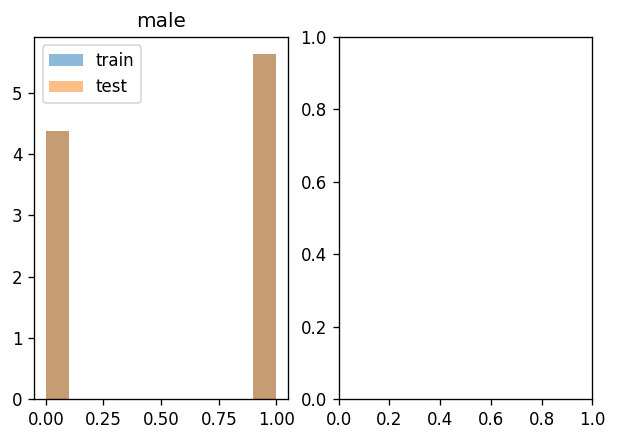

In [40]:

var_N = 11

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].hist(x_train[:,var_N], density=True, alpha=0.5)
axes[0].hist(x_test[:,var_N], density=True, alpha=0.5)
axes[0].legend(['train', 'test'])
axes[0].set_title(var_names_flat[dname][var_N])

bins = [-5, -4, -3, -2, -1.5, -1, -0.5, 0, 0.5, 1, 1.5, 2, 3, 4, 5]
center_bins = ((np.array([0] + bins) + np.array(bins + [0]))/2)[1:]
center_bins[-1] = bins[-1]

bin_idx = np.digitize(x_train[:, var_N], bins, right=False)
bin_means = []
bin_stds = []
aleatoric_mean = []
aleatoric_stds = []
epistemic_mean = []
epistemic_stds = []

for n_bin, bin_start in enumerate(bins):
    y_select = y_train[bin_idx==n_bin]
    aleatoric_select = tr_aleatoric_vec[bin_idx==n_bin]
    epistemic_select = tr_epistemic_vec[bin_idx==n_bin]
    if len(y_select) == 0:
        bin_means.append(np.nan)
        bin_stds.append(np.nan)
        aleatoric_mean.append(np.nan)
        aleatoric_stds.append(np.nan)
        epistemic_mean.append(np.nan)
        epistemic_stds.append(np.nan)
    else:
        print(aleatoric_select)
        bin_means.append(y_select.mean())
        bin_stds.append(y_select.std())
        aleatoric_mean.append(aleatoric_select.mean())
        aleatoric_stds.append(aleatoric_select.std())
        epistemic_mean.append(epistemic_select.mean())
        epistemic_stds.append(epistemic_select.std())

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, bin_means, yerr=bin_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('target var')

plt.tight_layout()

fig, axes = plt.subplots(1, 2, dpi=120)
# plt.figure(dpi=80)
axes[0].errorbar(center_bins, aleatoric_mean, yerr=aleatoric_stds, fmt='o')
axes[0].set_xlabel(var_names_flat[dname][var_N])
axes[0].set_ylabel('Aleatoric')
# plt.show()

# plt.figure(dpi=80)
axes[1].errorbar(center_bins, epistemic_mean, yerr=epistemic_stds, fmt='o')
axes[1].set_xlabel(var_names_flat[dname][var_N])
axes[1].set_ylabel('Epistemic')

plt.tight_layout()
# plt.show()

In [41]:
aleatoric_mean

[]

In [42]:
epistemic_mean

[]

In [43]:
use_index = uncertainty_idxs_sorted 

Nbatch = 512
z_init_batch = z_test[use_index[:Nbatch]]
x_init_batch = x_test[use_index[:Nbatch]]
y_init_batch = y_test[use_index[:Nbatch]]

NameError: name 'uncertainty_idxs_sorted' is not defined

In [44]:
use_index

NameError: name 'use_index' is not defined

## Run base CLUE


In [40]:
from torch.optim import Adam

class CLUE(BaseNet):
    """This will be a general class for CLUE, etc.
    A propper optimiser will be used instead of my manually designed one."""

    def __init__(self, VAE, BNN, original_x, uncertainty_weight, aleatoric_weight, epistemic_weight, prior_weight, distance_weight,
                 latent_L2_weight, prediction_similarity_weight,
                 lr, desired_preds=None, cond_mask=None, distance_metric=None, z_init=None, norm_MNIST=False, flatten_BNN=False,
                 regression=False, prob_BNN=True, cuda=True):

        """Option specification:
        MNIST: boolean, specifies whether to apply normalisation to VAE outputs before being passed on to the BNN"""
         # Load models
        self.VAE = VAE
        self.BNN = BNN
        self.BNN.set_mode_train(train=False)
        self.VAE.set_mode_train(train=False)

        # Objective function definition
        self.uncertainty_weight = uncertainty_weight
        self.aleatoric_weight = aleatoric_weight
        self.epistemic_weight = epistemic_weight
        self.prior_weight = prior_weight
        self.distance_weight = distance_weight
        self.distance_metric = distance_metric

        self.latent_L2_weight = latent_L2_weight
        self.prediction_similarity_weight = prediction_similarity_weight
        self.desired_preds = desired_preds
        # if self.desired_preds is not None:
        #     self.desired_preds = torch.Tensor(self.desired_preds)
            # if not regression:
            #     self.desired_preds = self.desired_preds#.type(torch.LongTensor)

        # Other CLUE parameters
        self.regression = regression
        # self.vae_sig = vae_sig  # We dont actually use this in our CLUE generative models as it performs worse
        self.flatten_BNN = flatten_BNN
        self.norm_MNIST = norm_MNIST
        self.original_x = torch.Tensor(original_x)


        self.prob_BNN = prob_BNN
        self.cuda = cuda
        if self.cuda:
            self.original_x = self.original_x.cuda()
            # self.z_init = self.z_init.cuda()
            if self.desired_preds is not None:
                self.desired_preds = self.desired_preds.cuda()
        self.cond_mask = cond_mask

        # Trainable params
        self.trainable_params = list()

        if self.VAE is None:  # this will be for ablation test: sensitivity analisys
            self.trainable_params.append(nn.Parameter(original_x))
        else:
            self.z_dim = VAE.latent_dim
            if z_init is not None:
                self.z_init = torch.Tensor(z_init)
                if cuda:
                    self.z_init = self.z_init.cuda()
                self.z = nn.Parameter(self.z_init)
                self.trainable_params.append(self.z)
            else:
                self.z_init = torch.zeros(self.z_dim).unsqueeze(0).repeat(original_x.shape[0],1)
                if self.cuda:
                    self.z_init = self.z_init.cuda()
                self.z = nn.Parameter(self.z_init)
                self.trainable_params.append(self.z)

        # Optimiser
        self.optimizer = Adam(self.trainable_params, lr=lr)
        # SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)

    def randomise_z_init(self, std):
        # assert (self.z.data == self.z_init).all()
        eps = torch.randn(self.z.shape).type(self.z.type())
        self.z.data = std * eps + self.z_init
        return None

    def pred_dist(self, preds):
        # We dont implement for now as we could just use VAEAC with class conditioning
        assert self.desired_preds is not None

        if self.regression:
            dist = F.mse_loss(preds, self.desired_preds, reduction='none')
        else:

            if len(self.desired_preds.shape) == 1 or self.desired_preds.shape[1] == 1:
                dist = F.nll_loss(preds, self.desired_preds, reduction='none')
            else:  # Soft cross entropy loss
                dist = -(torch.log(preds) * self.desired_preds).sum(dim=1)
        return dist

    def uncertainty_from_z(self):
        # if self.vae_sig:
        #     x = self.VAE.regenerate(self.z, grad=True).loc
        # else:
        # We dont use unflatten option because BNNs always take flattened input and unflatten doesnt support grad
        x = self.VAE.regenerate(self.z, grad=True)

        if self.flatten_BNN:
            to_BNN = x.view(x.shape[0], -1)
        else:
            to_BNN = x

        if self.norm_MNIST:
            to_BNN = MNIST_mean_std_norm(to_BNN)

        if self.prob_BNN:
            if self.regression:
                mu_vec, std_vec = self.BNN.sample_predict(to_BNN, Nsamples=0, grad=False) # True
                total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = decompose_std_gauss(mu_vec, std_vec)
                preds = mu_vec.mean(dim=0)
            else:
                probs = self.BNN.sample_predict(to_BNN, Nsamples=0, grad=False) # True
                total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty = decompose_entropy_cat(probs)
                preds = probs.mean(dim=0)
        else:
            if self.regression:
                mu, std = self.BNN.predict(to_BNN, grad=True)
                total_uncertainty = std.squeeze(1)
                aleatoric_uncertainty = total_uncertainty
                epistemic_uncertainty = total_uncertainty*0
                preds = mu
            else:
                probs = self.BNN.predict(to_BNN, grad=True)
                total_uncertainty = -(probs * torch.log(probs + 1e-10)).sum(dim=1, keepdim=False)
                aleatoric_uncertainty = total_uncertainty
                epistemic_uncertainty = total_uncertainty*0
                preds = probs

        return total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, x, preds

    def get_objective(self, x, total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, preds):
        # Put objectives together
        objective = self.uncertainty_weight * total_uncertainty + self.aleatoric_weight * aleatoric_uncertainty + \
                    self.epistemic_weight * epistemic_uncertainty

        if self.VAE is not None and self.cond_mask is None and self.prior_weight > 0:
            try:
                prior_loglike = self.VAE.prior.log_prob(self.z).sum(dim=1)
            except:  # This mode is just for CondCLUE but the objective method is inherited
                prior_loglike = self.VAEAC.get_prior(self.original_x, self.cond_mask, flatten=False).log_prob(self.z).sum(dim=1)
            objective += self.prior_weight * prior_loglike

        if self.latent_L2_weight != 0 and self.latent_L2_weight is not None:
            # print('latent_L2_weight is not implement correctly as distances are computed across batches')
            latent_dist = F.mse_loss(self.z, self.z_init, reduction='none').view(x.shape[0], -1).sum(dim=1)
            objective += self.latent_L2_weight * latent_dist

        if self.desired_preds is not None:
            pred_dist = self.pred_dist(preds).view(preds.shape[0], -1).sum(dim=1)
            objective += self.prediction_similarity_weight * pred_dist

        if self.distance_metric is not None:
            dist = self.distance_metric(x, self.original_x).view(x.shape[0], -1).sum(dim=1)
            objective += self.distance_weight * dist

            return objective, self.distance_weight*dist
        else:
            return objective, 0

    def optimise(self, min_steps=3, max_steps=25,
                 n_early_stop=3):
        # Vectors to capture changes for this minibatch
        z_vec = [self.z.data.cpu().numpy()]
        x_vec = []
        uncertainty_vec = np.zeros((max_steps, self.z.shape[0]))
        aleatoric_vec = np.zeros((max_steps, self.z.shape[0]))
        epistemic_vec = np.zeros((max_steps, self.z.shape[0]))
        dist_vec = np.zeros((max_steps, self.z.shape[0]))
        cost_vec = np.zeros((max_steps, self.z.shape[0]))  # this one doesnt consider the prior

        it_mask = np.zeros(self.z.shape[0])

        for step_idx in range(max_steps):

            self.optimizer.zero_grad()
            total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, x, preds = self.uncertainty_from_z()
            objective, w_dist = self.get_objective(x, total_uncertainty, aleatoric_uncertainty, epistemic_uncertainty, preds)
            # We sum over features and over batch size in order to make dz invariant of batch (used to average over batch size)
            objective.sum(dim=0).backward()  # backpropagate

            self.optimizer.step()

            # save vectors
            uncertainty_vec[step_idx, :] = total_uncertainty.data.cpu().numpy()
            aleatoric_vec[step_idx, :] = aleatoric_uncertainty.data.cpu().numpy()
            epistemic_vec[step_idx, :] = epistemic_uncertainty.data.cpu().numpy()
            dist_vec[step_idx, :] = (w_dist.data.cpu().numpy())
            cost_vec[step_idx, :] = (objective.data.cpu().numpy())
            x_vec.append(x.data)  # we dont convert to numpy yet because we need x0 for L1
            z_vec.append(self.z.data.cpu().numpy())  # this one is after gradient update while x is before

            it_mask = CLUE.update_stopvec(cost_vec, it_mask, step_idx, n_early_stop, min_steps)

        #  Generate final (or resulting s sample)

        x = self.VAE.regenerate(self.z, grad=False).data
        x_vec.append(x)
        x_vec = [i.cpu().numpy() for i in x_vec]  # convert x to numpy
        x_vec = np.stack(x_vec)
        z_vec = np.stack(z_vec)

        # Recover correct indexes using mask
        uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec, z_vec, x_vec = CLUE.apply_stopvec(it_mask,
                      uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec, z_vec, x_vec,
                      n_early_stop)
        return z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec

    @staticmethod
    def update_stopvec(cost_vec, it_mask, step_idx, n_early_stop, min_steps):
        # TODO: can go in a CLUE parent class
        asymptotic_rel = np.abs(cost_vec[step_idx - n_early_stop, :] - cost_vec[step_idx, :]) < cost_vec[0, :] * 1e-2
        asymptotic_abs = np.abs(cost_vec[step_idx - n_early_stop, :] - cost_vec[step_idx, :]) < 1e-3

        if step_idx > min_steps:
            condition_sum = asymptotic_rel + asymptotic_abs
        else:
            condition_sum = np.array([0])

        stop_vec = condition_sum.clip(max=1, min=0)

        to_mask = (it_mask == 0).astype(int) * stop_vec
        it_mask[to_mask == 1] = step_idx

        if (it_mask == 0).sum() == 0 and n_early_stop > 0:
            print('it %d, all conditions met, stopping' % step_idx)
        return it_mask

    @staticmethod
    def apply_stopvec(it_mask, uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec, z_vec, x_vec, n_early_stop):
        # uncertainty_vec[step_idx, batch_size]
        it_mask = (it_mask - n_early_stop + 1).astype(int)
        for i in range(uncertainty_vec.shape[1]):
            if it_mask[i] > 0 and n_early_stop > 0:
                uncertainty_vec[it_mask[i]:, i] = uncertainty_vec[it_mask[i], i]
                epistemic_vec[it_mask[i]:, i] = epistemic_vec[it_mask[i], i]
                aleatoric_vec[it_mask[i]:, i] = aleatoric_vec[it_mask[i], i]
                cost_vec[it_mask[i]:, i] = cost_vec[it_mask[i], i]
                dist_vec[it_mask[i]:, i] = dist_vec[it_mask[i], i]
                z_vec[it_mask[i]:, i] = z_vec[it_mask[i], i]
                x_vec[it_mask[i]:, i] = x_vec[it_mask[i], i]
        return uncertainty_vec, epistemic_vec, aleatoric_vec, dist_vec, cost_vec, z_vec, x_vec


    def sample_explanations(self, n_explanations, init_std=0.15, min_steps=3, max_steps=25,
                                    n_early_stop=3):
    # This creates a new first axis and stacks outputs there
        full_x_vec = []
        full_z_vec = []
        full_uncertainty_vec = []
        full_aleatoric_vec = []
        full_epistemic_vec = []
        full_dist_vec = []
        full_cost_vec = []

        for i in range(n_explanations):

            self.randomise_z_init(std=init_std)

            torch.autograd.set_detect_anomaly(False)

            # clue_instance.optimizer = SGD(self.trainable_params, lr=lr, momentum=0.5, nesterov=True)
            z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = self.optimise(
                                                                    min_steps=min_steps, max_steps=max_steps,
                                                                    n_early_stop=n_early_stop)

            full_x_vec.append(x_vec)
            full_z_vec.append(z_vec)
            full_uncertainty_vec.append(uncertainty_vec)
            full_aleatoric_vec.append(aleatoric_vec)
            full_epistemic_vec.append(epistemic_vec)
            full_dist_vec.append(dist_vec)
            full_cost_vec.append(cost_vec)

        full_x_vec = np.concatenate(np.expand_dims(full_x_vec, axis=0), axis=0)
        full_z_vec = np.concatenate(np.expand_dims(full_z_vec, axis=0), axis=0)
        full_cost_vec = np.concatenate(np.expand_dims(full_cost_vec, axis=0), axis=0)
        full_dist_vec = np.concatenate(np.expand_dims(full_dist_vec, axis=0), axis=0)
        full_uncertainty_vec = np.concatenate(np.expand_dims(full_uncertainty_vec, axis=0), axis=0)
        full_aleatoric_vec = np.concatenate(np.expand_dims(full_aleatoric_vec, axis=0), axis=0)
        full_epistemic_vec = np.concatenate(np.expand_dims(full_epistemic_vec, axis=0), axis=0)

        return full_x_vec, full_z_vec, full_uncertainty_vec, full_aleatoric_vec, full_epistemic_vec, full_dist_vec, full_cost_vec

    @classmethod
    def batch_optimise(cls, VAE, BNN, original_x, uncertainty_weight, aleatoric_weight, epistemic_weight, prior_weight,
                       distance_weight, latent_L2_weight, prediction_similarity_weight, lr, min_steps=3, max_steps=25,
                       n_early_stop=3, batch_size=256, cond_mask=None, desired_preds=None,
                       distance_metric=None, z_init=None, norm_MNIST=False, flatten_BNN=False, regression=False,
                       prob_BNN=True, cuda=True):
    # This stacks outputs along the first (batch_size) axis
        full_x_vec = []
        full_z_vec = []
        full_uncertainty_vec = []
        full_aleatoric_vec = []
        full_epistemic_vec = []
        full_dist_vec = []
        full_cost_vec = []

        idx_iterator = generate_ind_batch(original_x.shape[0], batch_size=batch_size, random=False, roundup=True)
        for train_idx in idx_iterator:

            if z_init is not None:
                z_init_use = z_init[train_idx]
            else:
                z_init_use = z_init

            if desired_preds is not None:
                desired_preds_use = desired_preds[train_idx].data
            else:
                desired_preds_use = desired_preds

            CLUE_runner = cls(VAE, BNN, original_x[train_idx], uncertainty_weight, aleatoric_weight, epistemic_weight, prior_weight, distance_weight,
                              latent_L2_weight, prediction_similarity_weight, lr, cond_mask=cond_mask, distance_metric=distance_metric,
                              z_init=z_init_use, norm_MNIST=norm_MNIST, desired_preds=desired_preds_use,
                              flatten_BNN=flatten_BNN, regression=regression, prob_BNN=prob_BNN, cuda=cuda)

            z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = \
                CLUE_runner.optimise(min_steps=min_steps, max_steps=max_steps, n_early_stop=n_early_stop)

            full_x_vec.append(x_vec)
            full_z_vec.append(z_vec)
            full_uncertainty_vec.append(uncertainty_vec)
            full_aleatoric_vec.append(aleatoric_vec)
            full_epistemic_vec.append(epistemic_vec)
            full_dist_vec.append(dist_vec)
            full_cost_vec.append(cost_vec)

        full_x_vec = np.concatenate(full_x_vec, axis=1)
        full_z_vec = np.concatenate(full_z_vec, axis=1)
        full_cost_vec = np.concatenate(full_cost_vec, axis=1)
        full_dist_vec = np.concatenate(full_dist_vec, axis=1)
        full_uncertainty_vec = np.concatenate(full_uncertainty_vec, axis=1)
        full_aleatoric_vec = np.concatenate(full_aleatoric_vec, axis=1)
        full_epistemic_vec = np.concatenate(full_epistemic_vec, axis=1)

        return full_x_vec, full_z_vec, full_uncertainty_vec, full_aleatoric_vec, full_epistemic_vec, full_dist_vec, full_cost_vec


In [41]:
class Ln_distance(nn.Module):
    """If dims is None Compute across all dimensions except first"""
    def __init__(self, n, dim=None):
        super(Ln_distance, self).__init__()
        self.n = n
        self.dim = dim

    def forward(self, x, y):
        d = x - y
        if self.dim is None:
            self.dim = list(range(1, len(d.shape)))
        return torch.abs(d).pow(self.n).sum(dim=self.dim).pow(1./float(self.n))

def decompose_std_gauss(mu, sigma, sum_dims=True):
    # probs (Nsamples, batch_size, output_sims)
    aleatoric_var = (sigma**2).mean(dim=0)
    epistemic_var = ((mu ** 2).mean(dim=0) - mu.mean(dim=0) ** 2)
    total_var = aleatoric_var + epistemic_var
    if sum_dims:
        aleatoric_var = aleatoric_var.sum(dim=1)
        epistemic_var = epistemic_var.sum(dim=1)
        total_var = total_var.sum(dim=1)
    return total_var.sqrt(), aleatoric_var.sqrt(), epistemic_var.sqrt()

def decompose_entropy_cat(probs, eps=1e-10):
    # probs (Nsamples, batch_size, classes)
    posterior_preds = probs.mean(dim=0, keepdim=False)
    total_entropy = -(posterior_preds * torch.log(posterior_preds + eps)).sum(dim=1, keepdim=False)

    sample_preds_entropy = -(probs * torch.log(probs + eps)).sum(dim=2, keepdim=False)
    aleatoric_entropy = sample_preds_entropy.mean(dim=0, keepdim=False)

    epistemic_entropy = total_entropy - aleatoric_entropy

    # returns (batch_size)
    return total_entropy, aleatoric_entropy, epistemic_entropy

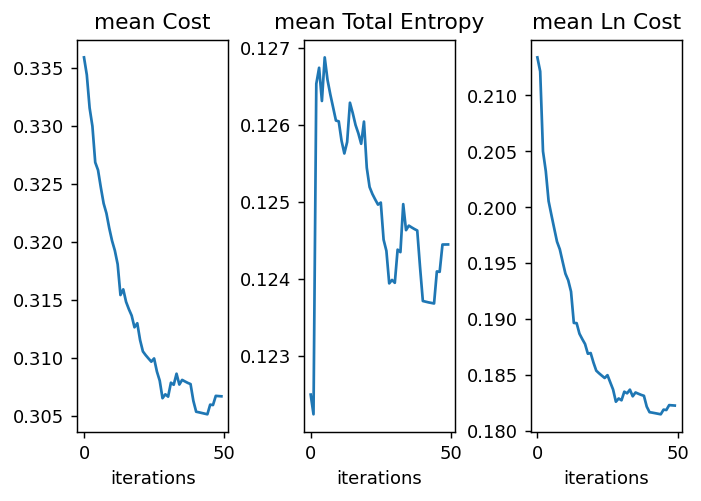

In [42]:
# from interpret.CLUE import CLUE
# from src.utils import Ln_distance
# from src.probability import decompose_std_gauss, decompose_entropy_cat

torch.cuda.empty_cache()

dist = Ln_distance(n=1, dim=(1))
x_dim = x_init_batch.reshape(x_init_batch.shape[0], -1).shape[1]


aleatoric_weight = 0
epistemic_weight = 0
uncertainty_weight = 1

distance_weight = 2 / x_dim
prediction_similarity_weight = 0


if regression_bools[names.index(dname)]:
    mu_vec, std_vec = BNN.sample_predict(x_init_batch, Nsamples=0, grad=False)
    o_uncert, o_aleatoric, o_epistemic = decompose_std_gauss(mu_vec, std_vec)
    desired_preds = mu_vec.mean(dim=0).cpu().numpy()
else:
    o_preds = BNN.sample_predict(x_init_batch, Nsamples=0, grad=False)
    o_uncert, o_aleatoric, o_epistemic = decompose_entropy_cat(o_preds)
    desired_preds = o_preds.mean(dim=0).cpu().numpy()


CLUE_explainer = CLUE(VAE, BNN, x_init_batch, uncertainty_weight=uncertainty_weight, aleatoric_weight=aleatoric_weight, epistemic_weight=epistemic_weight,
                      prior_weight=0, distance_weight=distance_weight,
                 latent_L2_weight=0, prediction_similarity_weight=prediction_similarity_weight,
                 lr=1e-2, desired_preds=None, cond_mask=None, distance_metric=dist,
                 z_init=z_init_batch, norm_MNIST=False,
                 flatten_BNN=False, regression=regression_bools[names.index(dname)], cuda=True)

torch.autograd.set_detect_anomaly(True)

z_vec, x_vec, uncertainty_vec, epistemic_vec, aleatoric_vec, cost_vec, dist_vec = CLUE_explainer.optimise(
                                                        min_steps=3, max_steps=50,
                                                        n_early_stop=3)

fig, axes = plt.subplots(1, 3, dpi=130)
axes[0].plot(cost_vec.mean(axis=1))
axes[0].set_title('mean Cost')
axes[0].set_xlabel('iterations')

axes[1].plot(uncertainty_vec.mean(axis=1))
axes[1].set_title('mean Total Entropy')
axes[1].set_xlabel('iterations')

axes[2].plot(dist_vec.mean(axis=1))
axes[2].set_title('mean Ln Cost')
axes[2].set_xlabel('iterations')

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=None)

## Plot histograms


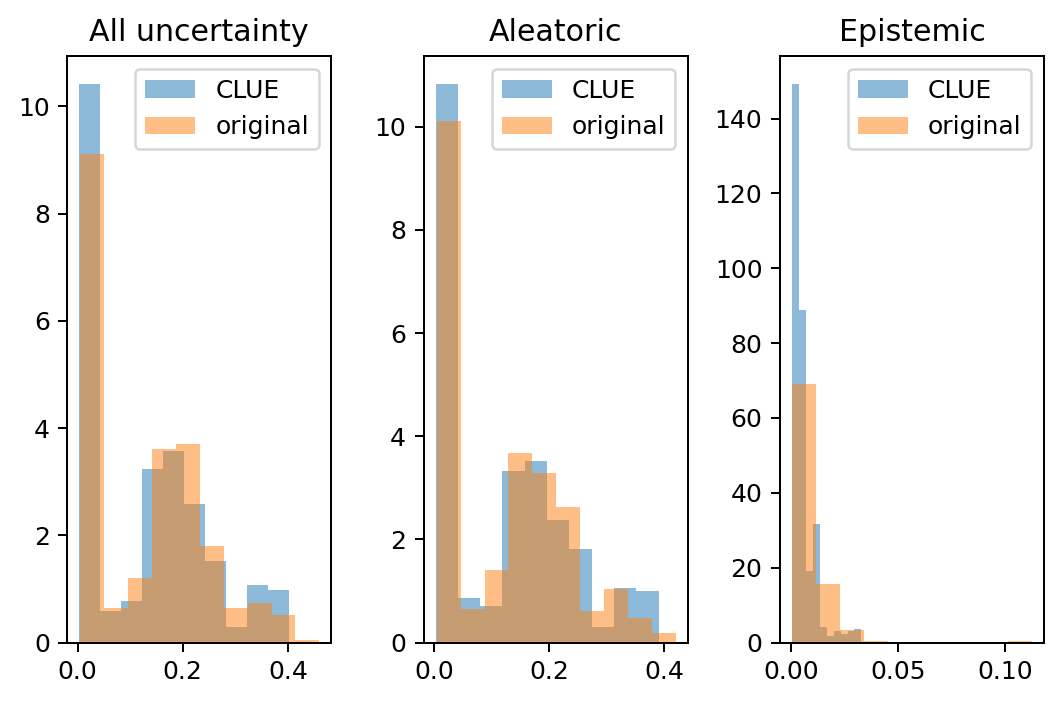

In [43]:
if regression_bools[names.index(dname)]:
    mu_vec, std_vec = BNN.sample_predict(x_vec[-1], Nsamples=0, grad=False)
    post_uncert, post_aleatoric, post_epistemic = decompose_std_gauss(mu_vec, std_vec)
    post_preds = mu_vec.mean(dim=0).cpu().numpy()
else:
    preds = BNN.sample_predict(x_vec[-1], Nsamples=0, grad=False)
    post_uncert, post_aleatoric, post_epistemic = decompose_entropy_cat(preds)
    post_preds = preds.mean(dim=0).cpu().numpy()[:,1]


fig, axes = plt.subplots(1, 3, dpi=180)
    

axes[0].hist(post_uncert.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[0].hist(te_uncertainty_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[0].set_title('All uncertainty')
axes[0].legend()

axes[1].hist(post_aleatoric.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[1].hist(te_aleatoric_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[1].set_title('Aleatoric')
axes[1].legend()

axes[2].hist(post_epistemic.cpu().numpy(), density=True, alpha=0.5, label='CLUE')
axes[2].hist(te_epistemic_vec[use_index[:Nbatch]], density=True, alpha=0.5, label='original')
axes[2].set_title('Epistemic')
axes[2].legend()

plt.tight_layout()

In [44]:
def gen_bar_plot(labels, data, title=None, xlabel=None, ylabel=None, probs=False, hor=False, save_file=None,
                 max_fields=40, fs=7, verbose=False, sort=False, dpi=40, neg_color=True, ax=None, c=None):
    if c is None:
        c = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
             '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
    c1 = c[0]
    c2 = c[1]  # ???

    add_tit = ''
    if data.shape[0] > max_fields or sort:
        if verbose:
            print(title + ' Demasiados campos de datos, mostrando %d mas grandes' % max_fields)
        add_tit = ' (top %d)' % max_fields
        abs_data = np.abs(data)
        sort_idx = np.flipud(np.argsort(abs_data))[:max_fields]
        labels = labels[sort_idx]
        data = data[sort_idx]

    if ax == None:
        plt.figure(dpi=dpi)
        ax = plt.gca()

    fst = 15

    if neg_color:
        c = np.array([c1] * data.shape[0])
        c[data < 0] = c2
    else:
        c = c1

    if hor:
        ax.barh(labels, data, 0.8, color=c)
        ax.invert_yaxis()
    else:
        ax.bar(labels, data, color=c)

    ax.xaxis.grid(alpha=0.35)
    ax.yaxis.grid(alpha=0.35)

    if title is not None:
        plt.title(title + add_tit)
    if xlabel is not None:
        ax.set_xlabel(xlabel)
    if ylabel is not None:
        ax.set_ylabel(ylabel)

    if probs and hor:
        ax.set_xlim((0, 1))
    elif probs and not hor:
        ax.set_ylim((0, 1))

    ax.title.set_fontsize(fst)
    for item in ([ax.xaxis.label, ax.yaxis.label] +
                 ax.get_xticklabels() + ax.get_yticklabels()):
        item.set_fontsize(fs)
        item.set_weight('normal')
    ax.legend(prop={'size': fs, 'weight': 'normal'}, frameon=False)

    ax.autoscale(enable=True, axis='x', tight=True)
    ax.autoscale(enable=True, axis='y', tight=True)
    #     plt.tight_layout()

    if save_file is not None:
        plt.savefig(save_file, bbox_inches='tight')

    return ax

No handles with labels found to put in legend.
No handles with labels found to put in legend.


o pred;  0.8276288 pred;  0.9051666


<AxesSubplot:title={'center':'clue 0.31358007'}>

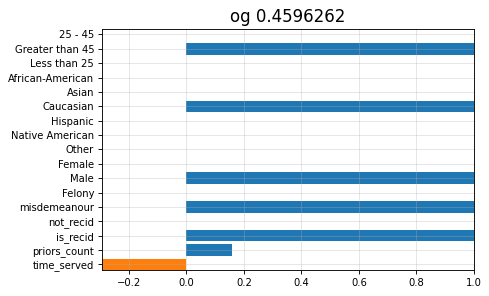

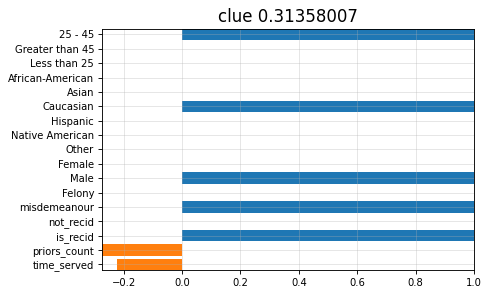

In [46]:
# from interpret.visualization_tools import gen_bar_plot

Nsample = 0#18# 1



print('o pred; ', desired_preds[Nsample,1], 'pred; ', post_preds[Nsample])

gen_bar_plot(var_names_flat[dname], x_init_batch[Nsample], title='og ' + str(te_uncertainty_vec[use_index[Nsample]]), xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
                 max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)

# gen_bar_plot(var_names_flat[dname], x_vec[0,Nsample,:], title='vae ' + str(uncertainty_vec[0,Nsample]), xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
#                  max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)

gen_bar_plot(var_names_flat[dname], x_vec[-1,Nsample,:], title='clue ' + str(post_uncert.cpu().numpy()[Nsample]), xlabel=None, ylabel=None, probs=False, hor=True, save_file=None,
                 max_fields=40, fs=9, verbose=False, sort=False, dpi=80, neg_color=True, ax=None, c=None)